In [2]:
import pennylane as qml
from pennylane import numpy as np
import random

In [3]:
"""We begin by creating many dictionaries which contain some of the properties
of each gate. Each key in the dictionary refers to a property we will be using to create
the circuit. 

"qub": (int) number of quits the gate acts on
"parametrized": (bool) tells us whether or not it is parametrized
"parameters": (int) number of parameters it receives, if it is parametrized. 0 otherwise
"entangling" (bool) whether or not a quantum gate induces entanglement.

"""
#Non-Parametric gates:
Hadamard = {"name":qml.Hadamard, "qub":1, "parametrized":False, "parameters": 0, "entangling":False};
PauliX = {"name":qml.PauliX, "qub":1, "parametrized":False, "parameters": 0, "entangling":False};
PauliY = {"name":qml.PauliY, "qub":1, "parametrized":False, "parameters": 0, "entangling":False};
PauliZ = {"name":qml.PauliZ, "qub":1, "parametrized":False, "parameters": 0, "entangling":False};
CNOT = {"name":qml.CNOT, "qub":2, "parametrized":False, "parameters": 0, "entangling":False};

# Parametrized gates
RZ = {"name":qml.RZ, "qub":1, "parametrized":True, "parameters": 1, "entangling":False};
RX = {"name":qml.RX, "qub":1, "parametrized":True, "parameters": 1, "entangling":False};
RY = {"name":qml.RY, "qub":1, "parametrized":True, "parameters": 1, "entangling":False};
CRZ = {"name":qml.CRZ, "qub":2, "parametrized":True, "parameters": 1, "entangling":True};
CRX = {"name":qml.CRX, "qub":2, "parametrized":True, "parameters": 1, "entangling":True};
CRY = {"name":qml.CRY, "qub":2, "parametrized":True, "parameters": 1, "entangling":True};
SWAP = {"name":qml.SWAP, "qub":2, "parametrized":False, "parameters": 0, "entangling":False};
T = {"name":qml.T, "qub":1, "parametrized":False, "parameters": 0, "entangling":False};

# 3-qubit gates:
CSWAP = {"name":qml.CSWAP, "qub":3, "parametrized":False, "parameters": 0, "entangling":True};
TOFFOLI = {"name":qml.Toffoli, "qub":3, "parametrized":False, "parameters": 0, "entangling":True};



Just as a reminder, we call a quantum gate entanglement-inducing if their action makes a state non-separable. Typically they come in the form of controlled-operations $C(G)$. In this case, their action is:
    
$$
C(G)|a\rangle |b\rangle = |a\rangle G^{(a)}|b\rangle
$$

where $G$ is the controlled operation subject to the value of $|a\rangle$. 

In [5]:
"""
We now construct a vector containing all possible gates that we can test.
We call it "compuertas", due to thats how we call gates in Spanish
"""

compuertas = [Hadamard, PauliX, PauliY, PauliZ, CNOT, RZ, RX, RY, CRZ, CRX, CRY, SWAP, CSWAP, T, TOFFOLI] #All gates
compuertas2 = [Hadamard, RZ, RX,RY, SWAP, T] #No entanglement-inducing gates
compuertas3 = [TOFFOLI, CSWAP] #Only 3 qubit-gates

In [6]:
"""
In this cell, we write the function that creates a random circuit.
Inputs:
compuertas (list): a list containing the gates to use
layers (int): the number of layers to apply to the circuit
"""

wires = 10
dev = qml.device('default.qubit', wires=wires)
@qml.qnode(dev)
def random_circuit(compuertas, layers):
    num_parameters = 0
    for u in range(layers):
        gate = random.choice(compuertas) #Select a random gate
        wir = random.sample(range(wires), gate["qub"])
        if gate["parametrized"]:
            angle = random.choice(np.linspace(-np.pi, np.pi, 200))
            gate["name"](angle,wires = wir)
            num_parameters = num_parameters + 1
        else:
            gate["name"](wires = wir)
            
    #TODO: Add a function to eliminate redundant gates
    
    return qml.density_matrix(wires = range(wires))
    
print(qml.draw(random_circuit)(compuertas, layers = 20))


0: ─╭●──────────────────────────╭●─────────────────────────────────────────────────╭●─╭SWAP
1: ─╰RZ(-2.13)──────────────────│────────────────────────────────────────╭RY(0.36)─│──│────
2: ─────────────────────────────│─────────────────────╭SWAP──Y───────────│─────────│──│────
3: ────────────╭●───────────────│─────────────────────│──────────────────│─────────├●─│────
4: ────────────│────────────────│─────────────────────│──────────────────│─────────│──│────
5: ────────────│────────────────│─────────────────────├SWAP──────────────│─────────│──│────
6: ─╭RY(0.52)──├SWAP────────────│──────────╭RX(-0.21)─│──────T───────────│─────────│──│────
7: ─│──────────│──────RY(-0.49)─╰RX(-1.50)─│──────────│──────────────────│─────────╰X─│────
8: ─╰●─────────│───────────────────────────╰●─────────│──────────────────│────────────╰SWAP
9: ────────────╰SWAP──────────────────────────────────╰●─────Z──RX(2.98)─╰●────────────────

──╭RX(1.94)──────────────────┤ ╭State
──│──────────────────────────┤ ├State
──│

However, this function just adds **one** gate per layer. Let's build a more sophisticated function:

What we can do is we can create a new function that creates a new **full** layer, this is, a layer where all qubits are being acted on. To do this, we create the function full_layer:

Parameters: 
* compuertas: (array) which tells us which gates to sue
* params: (array) to sue in case where we want to add parametrized layers
* wires: (int) number of wires to act on
* rand: (bool) whether or not we want to use random angles for our parametrized gates

In [45]:
def full_layer(compuertas, params, wires, rand):
    wires = [i for i in range(wires)]
    assorted = random.sample(wires, len(wires)) #We choose wires on which to act on

    #We choose theg ates!
    choices = [] #Array to save the order of the gates
    numero = 0 #Counter for the qubits
    while numero < len(wires): #We iterate over the qubits
        eleccion = random.choice(compuertas) #We choose which gates to use
        choices.append(eleccion) #Vector of gates to apply
        numero = numero + eleccion["qub"] #Total number of qubits these gates act on
        if numero > len(wires):
            #We must reduce our gate count. Eliminate one that has ONE gate
            eleccion = random.choice(range(len(choices))) #We randomly choose one that has one gate
            numero = numero - choices[eleccion]["qub"]
            choices.pop(eleccion)

    #We now apply the gates!
    for u in range(len(choices)): #We iterate over the applied gates
        if choices[u]["parametrized"]:
            if rand:
                angle = random.choice(np.linspace(-np.pi, np.pi, 200)) #If we want a random angle
            else: 
                angle = params[0: choices[u]["parameters"] ] #We select the angles from the parameters list. choices[u] tells us the number of angles to use
                if type(angle) == list:
                    angle = angle[0] #We get the angle i instead of [i]
            
            choices[u]["name"](angle, wires = assorted[u:u+ (choices[u]["qub"]) ])
        else:
            choices[u]["name"](wires = assorted[ u:u+ (choices[u]["qub"]) ] )
            
    #print(params)
    params = params[choices[u]["parameters"]:] #We make our parameter vector smaller
    #print(params)
    return params

Note that this is **not** a function that creates a circuit, instead it returns an array which is reduced in size, thus layer by layer it goes using all the angles in the angle array. We then create a new quantum function called adding_layers, which adds full-layers and outputs the density_matrix of the 

In [18]:
wires = 7
dev = qml.device('default.qubit', wires=wires)
@qml.qnode(dev)
def adding_layers(compuertas, params, layers, randi, wires = wires):
    parameters = params.copy() #We copy the initial vector parameter
    for u in range(layers):
        #_ = layer_by_layer(compuertas, params, rand = randi) #We go reducing the params vector
        _ = full_layer(compuertas, params, wires = wires, rand = randi) #We go reducing the params vector
        params = _
    return qml.density_matrix(wires = range(wires))


def layer_by_layer(compuertas, params, rand):
    "Esta función únicamente añade una sola compuerta por layer"
    gate = random.choice(compuertas) #Select a random gate
    
    if gate["qub"]==1:
        wir = random.choice(range(wires)) #Select a single random wire if gate is single qubit
    else:
        wir = random.sample(range(wires), gate["qub"]) #Select random wires
        
    if gate["parametrized"]:
        if rand:
            angle = random.choice(np.linspace(-np.pi, np.pi, 200)) #If we want a random angle
        else: 
            angle = params[0: gate["parameters"] ] #We select the angles
            if type(angle) == list:
                angle = angle[0] #We get the angle i instead of [i]
        gate["name"](angle,wires = wir)
    else:
        gate["name"](wires = wir)
        
    params = params[gate["parameters"]:] #We make our parameter vector smaller
    return params
        
print("Circuit with random angles sampled from -pi to pi:")
print(qml.draw(adding_layers)(compuertas, params = [i for i in range(0,40)], layers = 4, randi = True))
#qml.specs(adding_layers)(compuertas, params = [i for i in range(0,40)], layers = 4, randi = True)

Circuit with random angles sampled from -pi to pi:
0: ─╭●────────────────────────╭X─────────╭●─────────H──────────────┤ ╭State
1: ─│────────────────╭X─╭●────╰●─────────├X─────────────────────╭●─┤ ├State
2: ─├SWAP──RY(-0.14)─│──│──────RZ(-1.09)─╰●─────────────────────│──┤ ├State
3: ─│────────────────╰●─│─────╭RY(2.51)───RY(1.88)─╭●───────────├●─┤ ├State
4: ─│───────────────────│─────│────────────────────│──────────T─│──┤ ├State
5: ─│───────────────────├SWAP─╰●───────────────────│────────────│──┤ ├State
6: ─╰SWAP──H────────────╰SWAP──Y───────────────────╰RX(0.27)──T─╰X─┤ ╰State


In [19]:
print("Circuit with pre-established angles:")
print(qml.draw(adding_layers)(compuertas, params = [i for i in range(0,40)], layers = 4, randi = False))

Circuit with pre-established angles:
0: ──Z────────────────────────────────────────────────────────────────╭RZ(2.00)──H─┤ ╭State
1: ────╭●──Y────────╭●────────╭RY(1.00)──H────────────────────────────│──────────H─┤ ├State
2: ────├●──RY(0.00)─│─────────╰●──────────────────────────────────────│────────────┤ ├State
3: ────│────────────│─────────╭RY(0.00)─╭●─────────RZ(1.00)──Y────────│────────────┤ ├State
4: ──H─│────────────│─────────│─────────│─────────╭●──────────────────╰●───────────┤ ├State
5: ────╰X──X────────│─────────│─────────╰RZ(0.00)─│──────────RX(2.00)──────────────┤ ├State
6: ─────────────────╰RX(0.00)─╰●──────────────────╰X─────────RZ(1.00)──RY(2.00)────┤ ╰State


Then we can analyze the obtained quantum states obtained from these circuits. For this project we check the Renyi entropies:

In [43]:
def renyi(alpha, p):
    rho = p
    for u in range(alpha-1):
        rho = rho@p
    entropia = 1/(1-alpha)* np.log(np.trace(rho))
    return entropia

And now we analyze the behaviour of the renyi entropies according to circuits generated with or without entangling layers. We generate a number **trials** of states sampled from these quantum circuits and then apply check their entropies

/opt/conda/envs/pennylane/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0.5, 1.0, 'Average Renyi entropies of random unitaries with 35 layers and random angles over 5 repetitions for each layer')

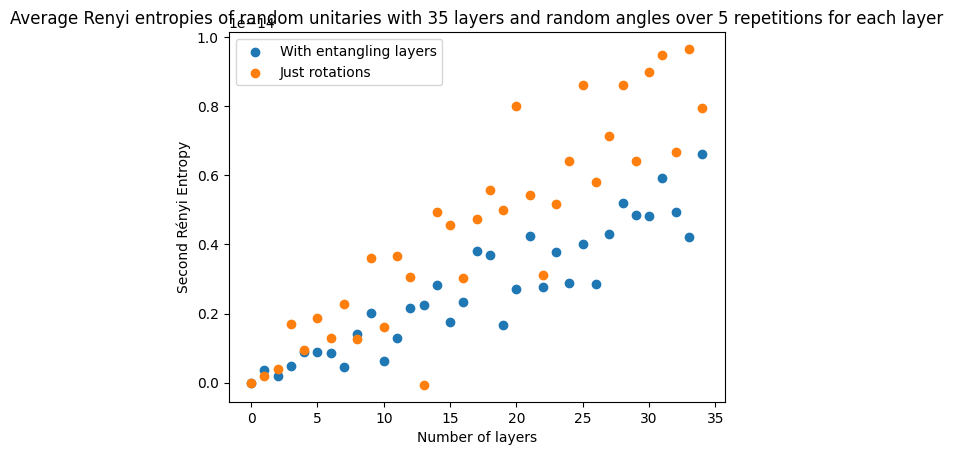

In [58]:
import matplotlib.pyplot as plt

compuertas = [Hadamard, PauliX, PauliY, PauliZ, CNOT, CRZ, CRX, CRY, SWAP, T] #Gates containing entangling gates
compuertas2 = [Hadamard, RZ, RX,RY, SWAP, T] #Gates NOT containing entangling layers

entropias = []
entropias2 = []
layers = [i for i in range(0,35)]
trials = 5 #How many circuits per layer?

for u in layers:
    so_far = 0
    so_far2 = 0
    for v in range(trials):
        vect = adding_layers(compuertas, params = [i for i in range(0, 500)], layers = u, randi = True)
        vect2 = adding_layers(compuertas2, params = [i for i in range(0, 500)], layers = u, randi = True)
        so_far = so_far + renyi(2,vect) #Sum of entropies
        so_far2 = so_far2 + renyi(2, vect2) #Sum of entropies
    entropias.append(so_far/trials) #We save the average entropy
    entropias2.append(so_far2/trials) #We save the average entropy

plt.scatter(layers, entropias, label = "With entangling layers")
plt.scatter(layers, entropias2, label = "Just rotations")
plt.xlabel("Number of layers")
plt.ylabel("Second Rényi Entropy")
plt.legend()
titulo = "Average Renyi entropies of random unitaries with " + str(max(layers)+1) + " layers and random angles over " + str(trials) + " repetitions for each layer"
plt.title(titulo)

In [59]:
import pandas as pd
pd.options.plotting.backend = "plotly"

entropia = pd.DataFrame({"Entangling": np.real(entropias), "Non-Entangling":np.real(entropias2)})
entropia.plot()